# An injection system

Here we inject a GW150914-like numerical-relativity waveform (SXS:BBH:0305, downloaded from [SXS's Catalog](https://data.black-holes.org/waveforms/index.html)) into LIGO Hanford's designed PSD (from [bilby](https://lscsoft.docs.ligo.org/bilby/)), and then use rational filters to study its ringdown signal.

In [334]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [335]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as pl
import qnm_filter
from scipy.special import logsumexp

### Construct the GW strain from numerical relativity

In [336]:
NRwaveform = qnm_filter.SXSWaveforms(filename="SXS:BBH:1107")
NRwaveform.get_remnant_data()

Found the following files to load from the SXS catalog:
    SXS:BBH:1107v5/Lev4/metadata.json


We focus on $(l=2,m=\pm2)$ harmonics

In [337]:
NRwaveform.import_sxs_data(l=2, m=2, interpolate=True, delta_t=0.05)
NRwaveform.import_sxs_data(l=2, m=-2, interpolate=True, delta_t=0.05)

NRwaveform.pad_data(partition=2, len_pow=1)

Found the following files to load from the SXS catalog:
    SXS:BBH:1107v5/Lev4/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:1107v5/Lev4/rhOverM_Asymptotic_GeometricUnits_CoM.h5


All SXS waveforms adopt geometric units with $G=c=M_\odot=1$, and normalize distance and time with BBH's total mass. Below we convert the waveform to SI units.

In [338]:
luminous_intensity = 440 # in Mpc
bbh_mass = 68 # BBH's total mass
NRwaveform.scale_to_si("padded_data", bbh_mass, luminous_intensity)

In [339]:
NRwaveform.data_in_si['22'] *= 1.5
NRwaveform.data_in_si['2-2'] *= 1.5

### Construct detector noise with `bilby`

In [340]:
sampling_frequency = 16384 # in Hz
duration = 7 # in second

Below we construct two `bilby.gw.detector.Interferometer` instances for comparision. One is noisy and the other one is noiseless.

In [341]:
bilby_ifo = qnm_filter.set_bilby_predefined_ifo('H1', sampling_frequency, duration, start_time=-duration/2)
bilby_ifo_no_noise = qnm_filter.set_bilby_predefined_ifo('H1', sampling_frequency, duration, 
                                                         start_time=-duration/2, zero_noise=True)

<AxesSubplot: >

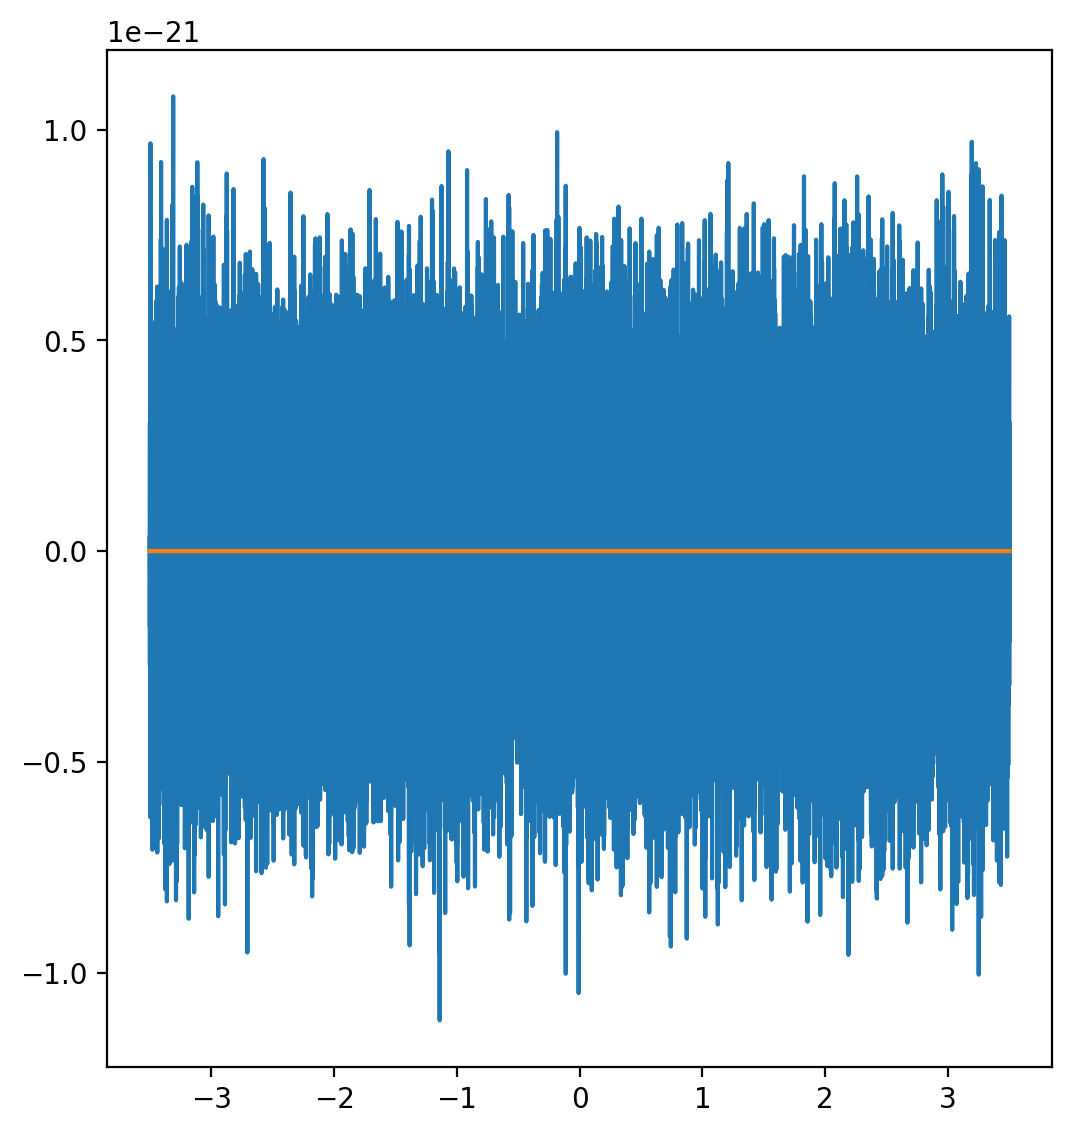

In [342]:
signalH_noise = qnm_filter.bilby_get_strain(bilby_ifo)
signalH_no_noise = qnm_filter.bilby_get_strain(bilby_ifo_no_noise)
signalH_noise.plot()
signalH_no_noise.plot()

### Inject the GW strain into noise

In [343]:
def NR_injection_into_Bilby(time, iota, beta, **waveform_kwargs):
    """A waveform function for `bilby.gw.waveform_generator.WaveformGenerator`
    
    Parameters
    ----------
    time : ndarray
        time stamps for waveform
    iota : float
        inclination angle, in radian.
    beta : float
        azimuth, in radian.
        
    Returns
    -------
    Dictionary
        A dictionary for plus and cross polarizations.
    """
    nr_dataset = NRwaveform.harmonics_to_polarizations("data_in_si", iota, beta, [(2,2), (2,-2)])
    hplus = nr_dataset['plus']
    hcross = nr_dataset['cross']
    hplus_interp_func = interp1d(hplus.time, hplus.values, bounds_error=False, fill_value=0)
    hcross_interp_func = interp1d(hcross.time, hcross.values, bounds_error=False, fill_value=0)

    hplus = hplus_interp_func(time)
    hcross = hcross_interp_func(time)

    return {'plus': hplus, 'cross': hcross}

In [344]:
bbh_spin1 = NRwaveform.get_bbh_spin1
bbh_spin2 = NRwaveform.get_bbh_spin2
injection_parameters = dict(mass_1=bbh_mass*NRwaveform.get_bbh_m1, mass_2=bbh_mass*NRwaveform.get_bbh_m2,
                            spin_1x=bbh_spin1[0], spin_1y=bbh_spin1[1], spin_1z=bbh_spin1[2],
                            spin_2x=bbh_spin2[0], spin_2y=bbh_spin2[1], spin_2z=bbh_spin2[2],
                            geocent_time=-duration/2,
                            iota=0, beta=0, 
                            ra=0, dec=0, psi=0, NRwaveform=NRwaveform)

Found the following files to load from the SXS catalog:
    SXS:BBH:1107v5/Lev4/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1107v5/Lev4/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1107v5/Lev4/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1107v5/Lev4/metadata.json


In [345]:
bilby_ifo_inj = qnm_filter.bilby_injection(bilby_ifo, NR_injection_into_Bilby, **injection_parameters)
bilby_ifo_inj_no_noise = qnm_filter.bilby_injection(bilby_ifo_no_noise, NR_injection_into_Bilby, 
                                                    **injection_parameters)

16:29 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: None
  time_domain_source_model: __main__.NR_injection_into_Bilby
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
16:29 bilby INFO    : Generation of source frame parameters failed with message 'luminosity_distance'
16:29 bilby INFO    : Injected signal in H1:
16:29 bilby INFO    :   optimal SNR = 38.49
16:29 bilby INFO    :   matched filter SNR = 38.17+0.56j
16:29 bilby INFO    :   mass_1 = 61.817758341795994
16:29 bilby INFO    :   mass_2 = 6.181884389549601
16:29 bilby INFO    :   spin_1x = -6.45030612062e-08
16:29 bilby INFO    :   spin_1y = -1.32091856513e-07
16:29 bilby INFO    :   spin_1z = 3.65619772075e-06
16:29 bilby INFO    :   spin_2x = 5.03608125798e-09
16:29 bilby INFO    :   spin_2y = 8.84272953694e-08
16:29 bilby INFO    :   spin_2z = 5.78387980902e-08
16:29 bilby INFO    :   geocent_time = -3.5
16:29 bilby INFO    :   iota = 0
16:29 bilby INF

In [346]:
signalH = qnm_filter.bilby_get_strain(bilby_ifo_inj)
signalH_no_noise = qnm_filter.bilby_get_strain(bilby_ifo_inj_no_noise)

(-0.1, 0.1)

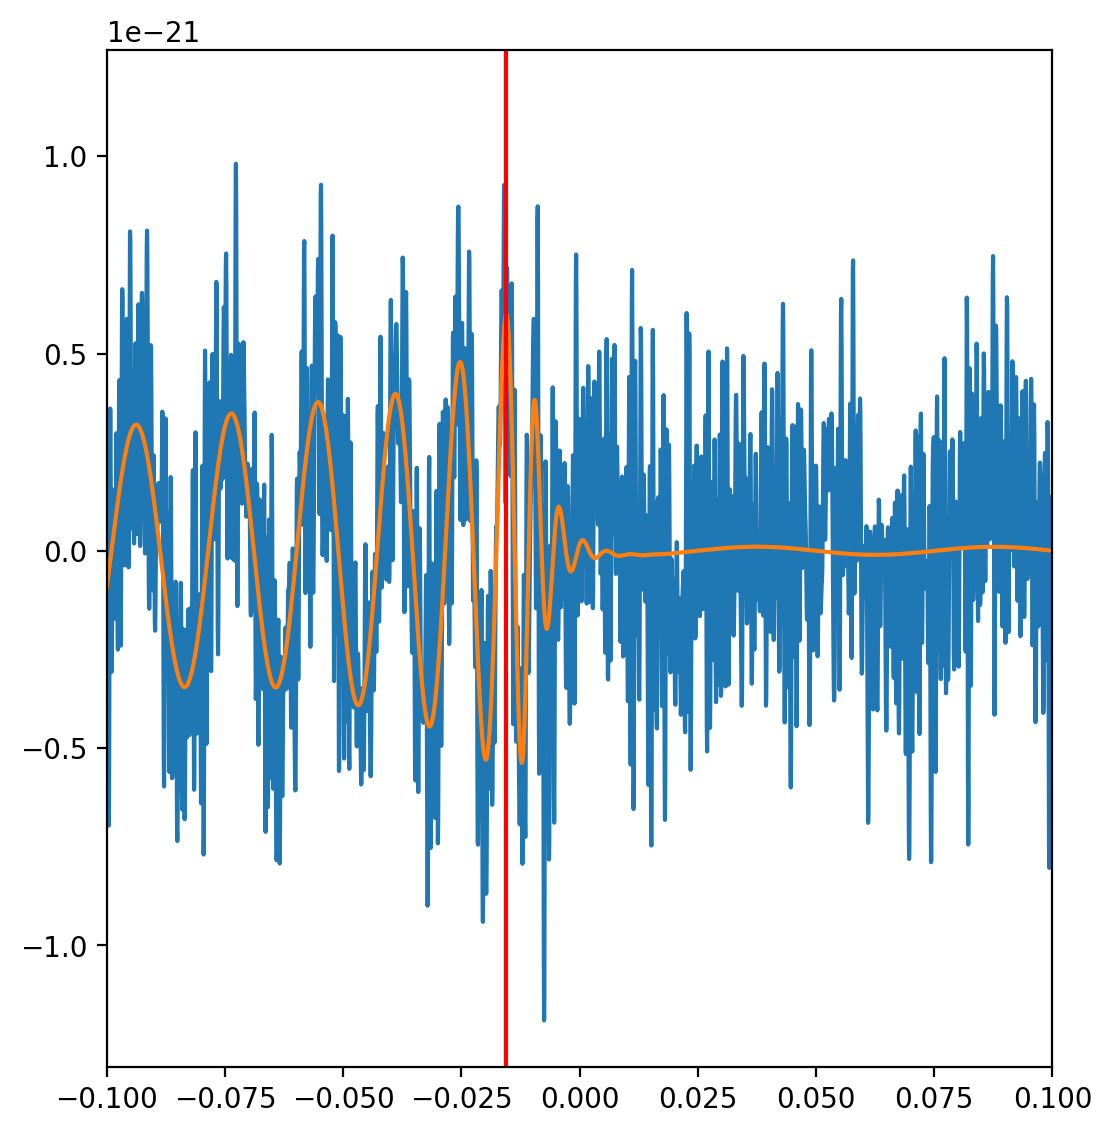

In [347]:
peak_time = signalH_no_noise.index[np.argmax(signalH_no_noise.values)]
signalH.plot()
signalH_no_noise.plot()
pl.axvline(peak_time, c = 'r')
pl.xlim(-0.1,0.1)

(-0.1, 0.1)

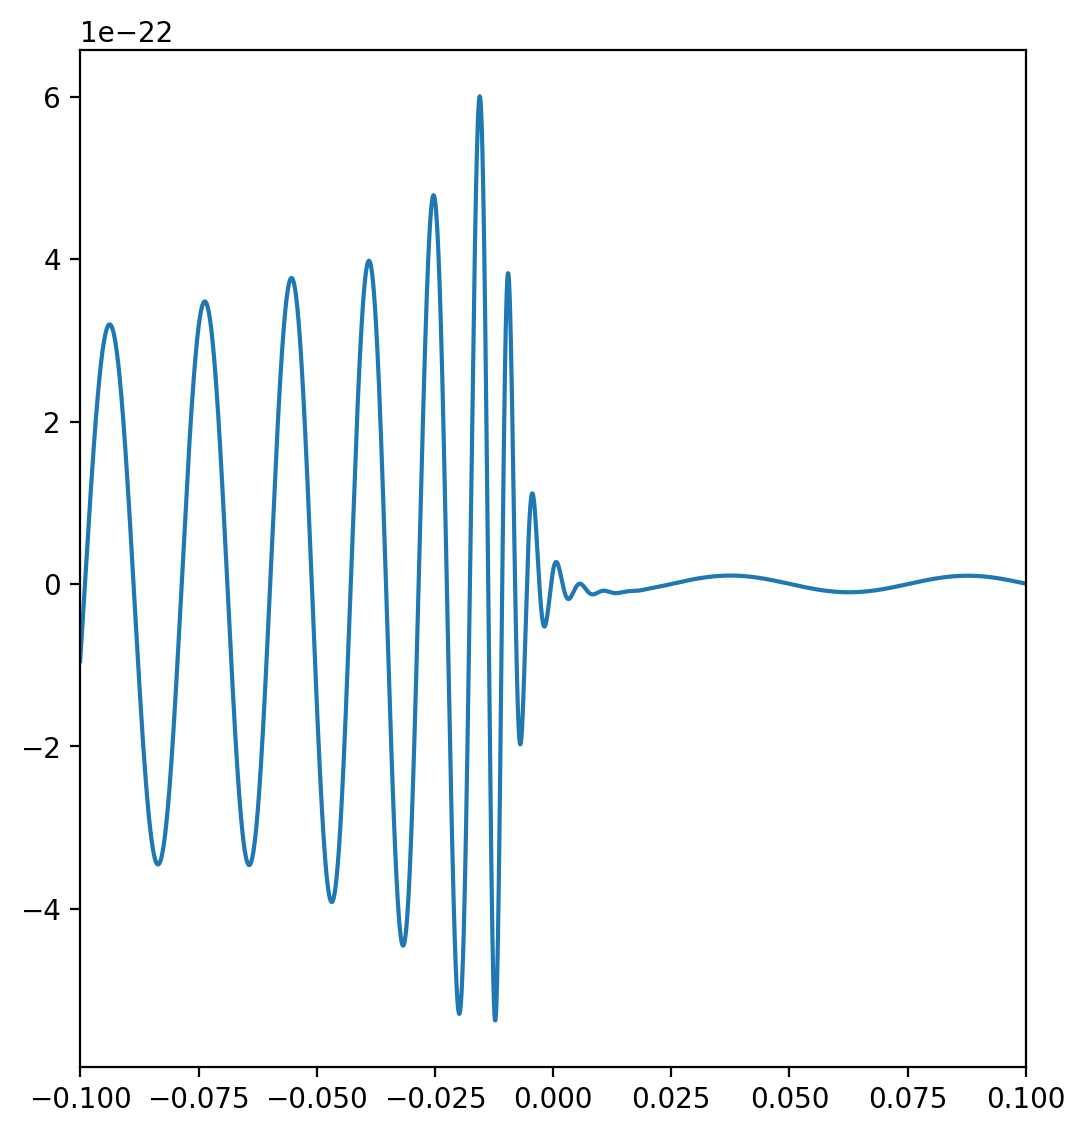

In [348]:
signalH_no_noise.plot()
pl.xlim(-0.1,0.1)

### Ringdown analysis with rational filter(s)

In [511]:
mass_unit = qnm_filter.Filter.mass_unit(NRwaveform.mf*bbh_mass)
input = dict(model_list = [(2, 2, 0, "p"), (2,2,1,'p'), (3,2,0,'p')\
                           ], #l, m, n
             # trucation time (geocenter, in second)
             t_init = peak_time+11*mass_unit, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

In [512]:
fit.original_data['H1'] = signalH
fit.detector_alignment()

In [513]:
fit.pure_noise = {}
fit.pure_noise['H1'] = signalH_noise

We use the Welch method to estimate the covariance matrix with pure noise. The estimation with `original_data` may break down when SNR is large enough

In [514]:
fit.condition_data('original_data')
fit.condition_data('pure_noise')
fit.compute_acfs('pure_noise')

In [515]:
fit.cholesky_decomposition()

## SNR

In [516]:
fit.first_index()
template = fit.truncate_data(fit.original_data)['H1']
fit.compute_SNR(0, template, 'H1', optimal=True)

30.99145093120227

Sampling remnant mass and spin

In [517]:
delta_mass = 1.0
delta_chi = 0.02
massspace = np.arange(34, 140, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

Interate over the samplings

In [518]:
fit.first_index()
likelihood_data, _ = qnm_filter.parallel_compute(fit, massspace, chispace, 
                                                 num_cpu = 9, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

Plot 2d contours

In [519]:
filters_str = '+'.join([''.join(str(i) for i in j) for j in input['model_list']])
time_str = str(np.round((input['t_init'] - peak_time)/mass_unit, 2))

Text(100, 0.1, 'ln(evidence) = -435.82')

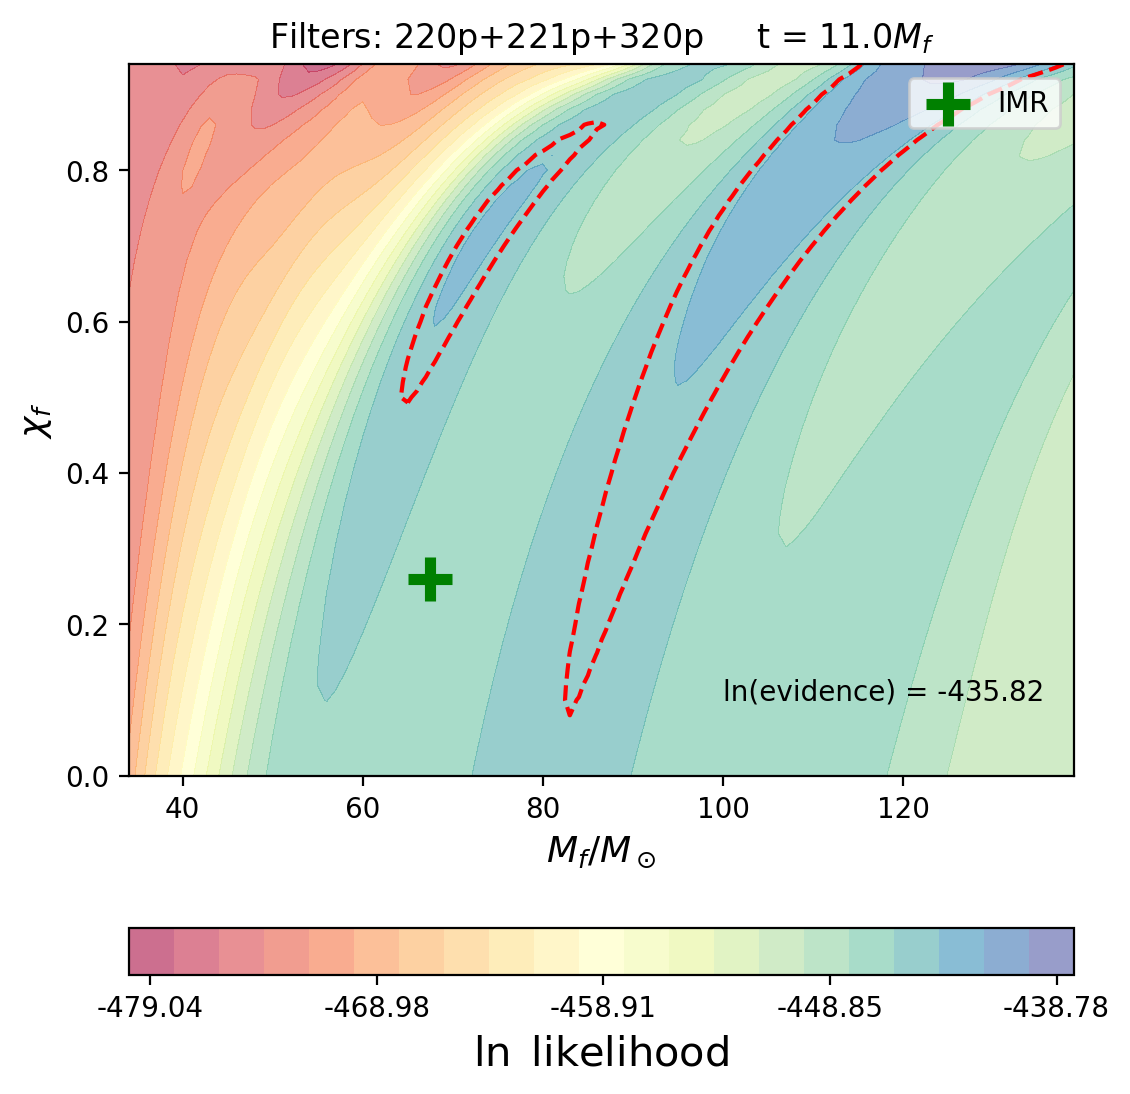

In [520]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=NRwaveform.mf*bbh_mass, y=NRwaveform.chif, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

pl.legend()
ax.set_title("Filters: " + filters_str + "     t = " + time_str + r'$M_f$')
ax.text(100, 0.1, 'ln(evidence) = %.2f' % logsumexp(likelihood_data))
# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')